In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [42]:
""" 
Estimate artist income based on total album sales
Converts total album sales to total stream equivalent using free account ratio of 3500 streams per album
Free account ratio is used due to lack of data on payout rates for premium account streams
Returns lower and upper bound of average payout per stream based on rates of $0.003 and $0.005
"""

def artist_earnings(total):

    per_stream = [0.003, 0.005]    
    payouts = []
    stream_equivalent = 3500 * total
    for rate in per_stream:
        payout = stream_equivalent *rate
        payouts.append(payout)

    return payouts

"""
Calculates the Difference in Differences for a given target variable
"""

def diff_in_diff(treat,control, target):
    
    treated_pre = treat[treat['post']==0]
    treated_post = treat[treat['post']==1]
    control_pre = control[control['post']==0]
    control_post = control[control['post']==1]

    treated_pre_mean = treated_pre[target].mean()
    treated_post_mean = treated_post[target].mean()
    control_pre_mean = control_pre[target].mean()
    control_post_mean = control_post[target].mean()

    treated_diff = treated_post_mean - treated_pre_mean
    control_diff = control_post_mean - control_pre_mean

    return treated_diff - control_diff

def bootstrap_DiD(data,target,ratio=0.25, b=1_000, n=1_000):

    halftime_artists = data[data['halftime']==1]
    control_artists = data[data['halftime']==0]

    diff_in_diffs = np.empty(n)
    num_samples = int(b*ratio)
    for i in range(n):
        halftime = halftime_artists.sample(n=num_samples, replace=True)
        control = control_artists.sample(n=(b-num_samples), replace=True)
        diff_in_diffs[i] = diff_in_diff(halftime,control,target)

    return diff_in_diffs



## Calculate artist earnings from diff-in-diff estimate

In [86]:
hdd_charts = pd.read_csv('..\\data\\hdd_charts.csv')
hdd_charts = hdd_charts[hdd_charts['date']!='2/3/2015']
hdd_charts = hdd_charts[hdd_charts['rank']!=0]
# Dropping some outliers caused by data errors
#hdd_charts = hdd_charts[(hdd_charts['artist']!='EMINEM') & (hdd_charts['artist']!='MAROON 5')]

In [77]:
n=1_000
totals=bootstrap_DiD(hdd_charts,'total',n=n, ratio=0.1)
payouts = np.empty((n,2))
np.random.seed(0)
for i in range(n):
    payouts[i] = artist_earnings(totals[i])

In [79]:
print("$0.003 mean: ", payouts[:,0].mean())
print("$0.003 se: ", payouts[:,0].std())
print("$0.005 mean: ", payouts[:,1].mean())
print("$0.005 se: ", payouts[:,1].std())
print('95% CI:', stats.norm.interval(0.95, loc=payouts[:,0].mean(), scale=payouts[:,0].std()))
print('95% CI:', stats.norm.interval(0.95, loc=payouts[:,1].mean(), scale=payouts[:,1].std()))


$0.003 mean:  165692.98359865087
$0.003 se:  76958.28057389504
$0.005 mean:  276154.97266441816
$0.005 se:  128263.80095649174
95% CI: (14857.52536168811, 316528.44183561363)
95% CI: (24762.54226948021, 527547.4030593561)


In [75]:
n=1_000
totals=bootstrap_DiD(hdd_charts,'total',n=n, ratio=0.25)
payouts = np.empty((n,2))
np.random.seed(0)
for i in range(n):
    payouts[i] = artist_earnings(totals[i])

print("$0.003 mean: ", payouts[:,0].mean())
print("$0.003 se: ", payouts[:,0].std())
print("$0.005 mean: ", payouts[:,1].mean())
print("$0.005 se: ", payouts[:,1].std())
print('95% CI:', stats.norm.interval(0.99, loc=payouts[:,0].mean(), scale=payouts[:,0].std()))
print('95% CI:', stats.norm.interval(0.99, loc=payouts[:,1].mean(), scale=payouts[:,1].std()))

$0.003 mean:  168095.41399347258
$0.003 se:  52897.94712937857
$0.005 mean:  280159.0233224543
$0.005 se:  88163.24521563094
95% CI: (31839.331680038827, 304351.49630690634)
95% CI: (53065.55280006473, 507252.4938448439)


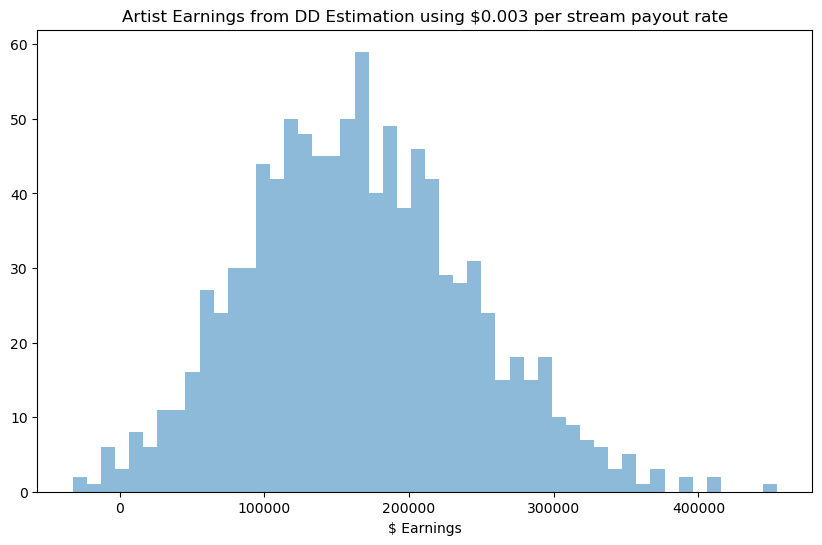

In [83]:
plt.figure(figsize=(10, 6))
plt.xlabel('$ Earnings')
plt.title('Artist Earnings from DD Estimation using $0.003 per stream payout rate')
plt.hist(payouts[:,0], bins=50, alpha=0.5, label='Payout Rate: $0.003')
plt.savefig('..\\images\\hdd_boot3.png')
plt.show()

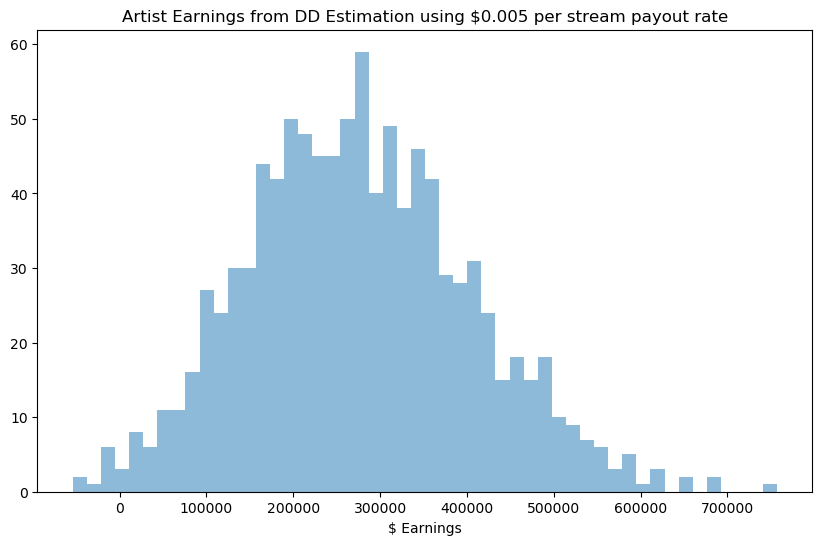

In [84]:
plt.figure(figsize=(10, 6))
plt.xlabel('$ Earnings')
plt.title('Artist Earnings from DD Estimation using $0.005 per stream payout rate')
plt.hist(payouts[:,1], bins=50, alpha=0.5, label='Payout Rate: $0.005')
plt.savefig('..\\images\\hdd_boot5.png')

plt.show()

## Check statistical significance after bootstrapping

In [20]:
hdd_charts = pd.read_csv('..\\data\\hdd_charts.csv')

In [74]:
diff_in_diffs = bootstrap_DiD(hdd_charts,'total')

print('Mean:', diff_in_diffs.mean())
print('SE: ', diff_in_diffs.std())
print('95% CI:', stats.norm.interval(0.99, loc=diff_in_diffs.mean(), scale=diff_in_diffs.std()))

Mean: 16391.135481134148
SE:  4825.850905938062
95% CI: (3960.5673030608796, 28821.703659207415)


In [73]:
diff_in_diffs = bootstrap_DiD(hdd_charts,'total', ratio=0.1)

print('Mean:', diff_in_diffs.mean())
print('SE: ', diff_in_diffs.std())
print('95% CI:', stats.norm.interval(0.99, loc=diff_in_diffs.mean(), scale=diff_in_diffs.std()))

Mean: 15780.284152252461
SE:  7329.360054656671
95% CI: (-3098.8962527929616, 34659.464557297884)
